## Ionization bubbles: test on a uniform box

Generate input layer of halo properties (initially just positions, later include mass), output layer of ionization field (volume occupied by ionized bubbles)

Box size $L_{box}\, = 80 h^{-1}$ comoving Mpc (not used for the test; added for using real simulation output)

Test grid setup: $N = 16$ cells, cell size 5 $h^{-1}$ comoving Mpc

Assumed bubble radius 2 cells, or 10 $h^{-1}$ comoving Mpc

Number of halos = 32

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('mplstyle.txt')

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

rng = np.random.default_rng(1)

2.9.0


### Generation of input and output, and timing

In [15]:
def GenerateRandomBox( Lbox = 80., N = 16, Rbubble = 4., Nhalos = 32, vectorize = True ):
    # Lbox = box size in h^{-1} Mpc
    # N = grid size
    # Rbubble = radius of ionized bubble in h^{-1} Mpc
    
    # generate 3D array of halo positions
    halos = np.zeros((N,N,N))
    halo_xyz = np.zeros((Nhalos,3))

    for nh in range(Nhalos):
        i = rng.integers(low=0, high=N, size=3)
        halo_xyz[nh] = i
        halos[i[0], i[1], i[2]] = 1

    # generate ionization bubbles
    ionization_field = np.zeros((N,N,N))

    if vectorize:
        xx, yy, zz, hh = np.meshgrid(range(N),range(N),range(N),range(Nhalos), indexing='ij', sparse=True)
        dr2 = (xx - halo_xyz[:,0])**2 + (yy - halo_xyz[:,1])**2 + (zz - halo_xyz[:,2])**2
        idx = np.where(dr2 < Rbubble**2)
        ionization_field[idx[:3]] = 1
    else:
        xx, yy, zz = np.meshgrid(range(N), range(N), range(N), indexing='ij', sparse=True)
        for nh in range(Nhalos):
            dr2 = (xx-halo_xyz[nh][0])**2 + (yy-halo_xyz[nh][1])**2 + (zz-halo_xyz[nh][2])**2
            ionization_field[dr2 < Rbubble**2] = 1
    
    return halos, ionization_field

In [16]:
# model parameters

n_train = 5000       # number of training boxes
n_val = n_train//5   # number of validation boxes
n_test = n_val       # number of test boxes

N = 16               # size of the grid N^3
Nhalos = 32          # number of halos in a box
Rbubble = 2.         # radius of a bubble
Lbox = 80.           # size of a box

In [17]:
%timeit -n 100 GenerateRandomBox( Lbox = Lbox, N = N, Rbubble = Rbubble, Nhalos = Nhalos, vectorize = False )

%timeit -n 100 GenerateRandomBox( Lbox = Lbox, N = N, Rbubble = Rbubble, Nhalos = Nhalos )

2.02 ms ± 58.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.87 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
# generate training, validation, and test datasets

x_train = np.ndarray((n_train, N, N, N)).astype(np.float32)
y_train = np.ndarray((n_train, N, N, N)).astype(np.float32)

x_val = np.ndarray((n_val, N, N, N)).astype(np.float32)
y_val = np.ndarray((n_val, N, N, N)).astype(np.float32)

x_test = np.ndarray((n_test, N, N, N)).astype(np.float32)
y_test = np.ndarray((n_test, N, N, N)).astype(np.float32)

for n in range(n_train):
    x_train[n], y_train[n] = GenerateRandomBox( Lbox = Lbox, N = N, Rbubble = Rbubble, Nhalos = Nhalos )

for n in range(n_val):
    x_val[n], y_val[n] = GenerateRandomBox( Lbox = Lbox, N = N, Rbubble = Rbubble, Nhalos = Nhalos )
    
for n in range(n_test):
    x_test[n], y_test[n] = GenerateRandomBox( Lbox = Lbox, N = N, Rbubble = Rbubble, Nhalos = Nhalos )

In [19]:
# save generated boxes

if False:
    np.savez('box_io_data.npz', x_train, y_train, x_val, y_val, x_test, y_test)

# read in generated boxes

if False:
    npzfile = np.load('box_io_data.npz')
    print(npzfile.files)
    print(x_train.shape, npzfile['arr_0'].shape)

### Model setup and calculation

In [20]:
# Convert numpy arrays of data to tensorflow dataframes, to speed up computational time
# cache: saves training data to ram in easy-to-access way
# shuffle: shuffles the training set each 'epoch' of training
# batch: sets the minibatch size for training and inference
# prefetch: pre-loads a few minibatches of data from the cache just before inference

batch_size = n_train//10

dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().shuffle(n_train, reshuffle_each_iteration=True).batch(batch_size).prefetch(3)

dataset_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).cache().batch(batch_size).prefetch(3)

In [21]:
# Construct 3D U_NET CNN model
# Specify layers and their interactions

FILTERS = 2  # this parameter tunes the complexity / number of parameters of the model

params_final = dict(kernel_size=(1, 1, 1), activation="sigmoid", padding="same")
params = dict(kernel_size=(3, 3, 3), activation="relu", padding="same")
params_maxpool = dict(size=(2, 2, 2))

input_layer = keras.layers.Input(shape=(N, N, N, 1), name="input_layer")

encoder_1_a = keras.layers.Conv3D(FILTERS, name='encoder_1_a', **params)(input_layer)
encoder_1_b = keras.layers.Conv3D(FILTERS, name='encoder_1_b', **params)(encoder_1_a)
downsample_1 = keras.layers.MaxPool3D(name='downsample_1')(encoder_1_b)

encoder_2_a = keras.layers.Conv3D(FILTERS*2, name='encoder_2_a', **params)(downsample_1)
encoder_2_b = keras.layers.Conv3D(FILTERS*2, name='encoder_2_b', **params)(encoder_2_a)
downsample_2 = keras.layers.MaxPool3D(name='downsample_2')(encoder_2_b)

encoder_3_a = keras.layers.Conv3D(FILTERS*4, name='encoder_3_a', **params)(downsample_2)
encoder_3_b = keras.layers.Conv3D(FILTERS*4, name='encoder_3_b', **params)(encoder_3_a)
downsample_3 = keras.layers.MaxPool3D(name='downsample_3')(encoder_3_b)

encoder_4_a = keras.layers.Conv3D(FILTERS*8, name='encoder_4_a', **params)(downsample_3)
encoder_4_b = keras.layers.Conv3D(FILTERS*8, name='encoder_4_b', **params)(encoder_4_a)

upsample_3 = keras.layers.UpSampling3D(name='upsample_3', **params_maxpool)(encoder_4_b)
concat_3 = keras.layers.concatenate([upsample_3, encoder_3_b], name='concat_3')
decoder_3_a = keras.layers.Conv3D(FILTERS*4, name='decoder_3_a', **params)(concat_3)
decoder_3_b = keras.layers.Conv3D(FILTERS*4, name='decoder_3_b', **params)(decoder_3_a)

upsample_2 = keras.layers.UpSampling3D(name='upsample_2', **params_maxpool)(decoder_3_b)
concat_2 = keras.layers.concatenate([upsample_2, encoder_2_b], name='concat_2')
decoder_2_a = keras.layers.Conv3D(FILTERS*2, name='decoder_2_a', **params)(concat_2)
decoder_2_b = keras.layers.Conv3D(FILTERS*2, name='decoder_2_b', **params)(decoder_2_a)

upsample_1 = keras.layers.UpSampling3D(name='upsample_1', **params_maxpool)(decoder_2_b)
concat_1 = keras.layers.concatenate([upsample_1, encoder_1_b], name='concat_1')
decoder_1_a = keras.layers.Conv3D(FILTERS, name='decoder_1_a', **params)(concat_1)
decoder_1_b = keras.layers.Conv3D(FILTERS, name='decoder_1_b', **params)(decoder_1_a)

output_layer = keras.layers.Conv3D(name="output_layer", filters=1, **params_final)(decoder_1_b)

print('Input size:', input_layer.shape)
print('Output size:', output_layer.shape)

model = keras.models.Model(inputs=input_layer, outputs=output_layer, name='cnn3d')

model.compile(optimizer=keras.optimizers.Nadam(learning_rate=1e-3), loss='binary_crossentropy',\
    metrics=[tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR'),\
            tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'acc'])

Input size: (None, 16, 16, 16, 1)
Output size: (None, 16, 16, 16, 1)


In [22]:
model.summary()

Model: "cnn3d"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 16, 16, 16,  0           []                               
                                 1)]                                                              
                                                                                                  
 encoder_1_a (Conv3D)           (None, 16, 16, 16,   56          ['input_layer[0][0]']            
                                2)                                                                
                                                                                                  
 encoder_1_b (Conv3D)           (None, 16, 16, 16,   110         ['encoder_1_a[0][0]']            
                                2)                                                            

In [23]:
# Train the model using early stopping criterion

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='recall', min_delta=0, patience=5, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(dataset_train, verbose=1, epochs=300,
                    validation_data=dataset_val, callbacks=early_stopping)

Epoch 1/300
10/10 [==============================] - 29s 3s/step - loss: 0.6773 - auc_2: 0.4612 - auc_3: 0.1550 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - acc: 0.8305 - val_loss: 0.5356 - val_auc_2: 0.4595 - val_auc_3: 0.1514 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_acc: 0.8309
Epoch 2/300
10/10 [==============================] - 25s 3s/step - loss: 0.5352 - auc_2: 0.4644 - auc_3: 0.1534 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - acc: 0.8305 - val_loss: 0.5130 - val_auc_2: 0.4587 - val_auc_3: 0.1517 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_acc: 0.8309
Epoch 3/300
10/10 [==============================] - 25s 3s/step - loss: 0.5066 - auc_2: 0.4632 - auc_3: 0.1532 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - acc: 0.8305 - val_loss: 0.4992 - val_auc_2: 0.4667 - val_auc_3: 0.1536 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_acc: 0.8309
Epoch 4/300
10/10 [==============================] - 25s 3s/step - loss: 

Epoch 28/300
10/10 [==============================] - 25s 2s/step - loss: 0.1823 - auc_2: 0.9825 - auc_3: 0.8865 - precision_1: 0.9150 - recall_1: 0.5850 - acc: 0.9204 - val_loss: 0.1795 - val_auc_2: 0.9857 - val_auc_3: 0.9080 - val_precision_1: 0.9371 - val_recall_1: 0.5465 - val_acc: 0.9171
Epoch 29/300
10/10 [==============================] - 25s 2s/step - loss: 0.1781 - auc_2: 0.9841 - auc_3: 0.8954 - precision_1: 0.9205 - recall_1: 0.6140 - acc: 0.9256 - val_loss: 0.1748 - val_auc_2: 0.9868 - val_auc_3: 0.9132 - val_precision_1: 0.9388 - val_recall_1: 0.5846 - val_acc: 0.9233
Epoch 30/300
10/10 [==============================] - 25s 2s/step - loss: 0.1742 - auc_2: 0.9855 - auc_3: 0.9027 - precision_1: 0.9253 - recall_1: 0.6412 - acc: 0.9304 - val_loss: 0.1717 - val_auc_2: 0.9880 - val_auc_3: 0.9203 - val_precision_1: 0.9440 - val_recall_1: 0.6006 - val_acc: 0.9264
Epoch 31/300
10/10 [==============================] - 25s 2s/step - loss: 0.1709 - auc_2: 0.9866 - auc_3: 0.9096 - pre

Epoch 56/300
10/10 [==============================] - 25s 2s/step - loss: 0.1081 - auc_2: 0.9993 - auc_3: 0.9946 - precision_1: 0.9924 - recall_1: 0.9354 - acc: 0.9878 - val_loss: 0.1071 - val_auc_2: 0.9995 - val_auc_3: 0.9956 - val_precision_1: 0.9940 - val_recall_1: 0.9260 - val_acc: 0.9865
Epoch 57/300
10/10 [==============================] - 25s 3s/step - loss: 0.1067 - auc_2: 0.9994 - auc_3: 0.9950 - precision_1: 0.9929 - recall_1: 0.9396 - acc: 0.9886 - val_loss: 0.1058 - val_auc_2: 0.9995 - val_auc_3: 0.9961 - val_precision_1: 0.9944 - val_recall_1: 0.9300 - val_acc: 0.9873
Epoch 58/300
10/10 [==============================] - 25s 2s/step - loss: 0.1054 - auc_2: 0.9995 - auc_3: 0.9956 - precision_1: 0.9933 - recall_1: 0.9435 - acc: 0.9894 - val_loss: 0.1046 - val_auc_2: 0.9996 - val_auc_3: 0.9964 - val_precision_1: 0.9949 - val_recall_1: 0.9331 - val_acc: 0.9879
Epoch 59/300
10/10 [==============================] - 25s 2s/step - loss: 0.1043 - auc_2: 0.9995 - auc_3: 0.9957 - pre

Epoch 84/300
10/10 [==============================] - 25s 2s/step - loss: 0.0824 - auc_2: 0.9999 - auc_3: 0.9989 - precision_1: 0.9973 - recall_1: 0.9857 - acc: 0.9971 - val_loss: 0.0818 - val_auc_2: 0.9999 - val_auc_3: 0.9987 - val_precision_1: 0.9970 - val_recall_1: 0.9873 - val_acc: 0.9974
Epoch 85/300
10/10 [==============================] - 25s 3s/step - loss: 0.0817 - auc_2: 0.9999 - auc_3: 0.9989 - precision_1: 0.9974 - recall_1: 0.9862 - acc: 0.9972 - val_loss: 0.0813 - val_auc_2: 0.9999 - val_auc_3: 0.9987 - val_precision_1: 0.9966 - val_recall_1: 0.9892 - val_acc: 0.9976
Epoch 86/300
10/10 [==============================] - 25s 3s/step - loss: 0.0811 - auc_2: 0.9999 - auc_3: 0.9989 - precision_1: 0.9973 - recall_1: 0.9867 - acc: 0.9973 - val_loss: 0.0807 - val_auc_2: 0.9998 - val_auc_3: 0.9986 - val_precision_1: 0.9965 - val_recall_1: 0.9902 - val_acc: 0.9977
Epoch 87/300
10/10 [==============================] - 25s 3s/step - loss: 0.0804 - auc_2: 0.9999 - auc_3: 0.9990 - pre

Epoch 112/300
10/10 [==============================] - 25s 3s/step - loss: 0.0666 - auc_2: 0.9999 - auc_3: 0.9995 - precision_1: 0.9982 - recall_1: 0.9941 - acc: 0.9987 - val_loss: 0.0663 - val_auc_2: 0.9999 - val_auc_3: 0.9993 - val_precision_1: 0.9977 - val_recall_1: 0.9954 - val_acc: 0.9988
Epoch 113/300
10/10 [==============================] - 25s 3s/step - loss: 0.0662 - auc_2: 0.9999 - auc_3: 0.9995 - precision_1: 0.9982 - recall_1: 0.9943 - acc: 0.9987 - val_loss: 0.0658 - val_auc_2: 0.9999 - val_auc_3: 0.9994 - val_precision_1: 0.9980 - val_recall_1: 0.9949 - val_acc: 0.9988
Epoch 114/300
10/10 [==============================] - 25s 2s/step - loss: 0.0657 - auc_2: 0.9999 - auc_3: 0.9995 - precision_1: 0.9983 - recall_1: 0.9944 - acc: 0.9988 - val_loss: 0.0653 - val_auc_2: 0.9999 - val_auc_3: 0.9994 - val_precision_1: 0.9981 - val_recall_1: 0.9949 - val_acc: 0.9988
Epoch 115/300
10/10 [==============================] - 25s 3s/step - loss: 0.0652 - auc_2: 0.9999 - auc_3: 0.9995 -

Epoch 140/300
10/10 [==============================] - 25s 3s/step - loss: 0.0549 - auc_2: 1.0000 - auc_3: 0.9997 - precision_1: 0.9987 - recall_1: 0.9968 - acc: 0.9992 - val_loss: 0.0546 - val_auc_2: 1.0000 - val_auc_3: 0.9997 - val_precision_1: 0.9988 - val_recall_1: 0.9964 - val_acc: 0.9992
Epoch 141/300
10/10 [==============================] - 26s 3s/step - loss: 0.0545 - auc_2: 1.0000 - auc_3: 0.9997 - precision_1: 0.9988 - recall_1: 0.9968 - acc: 0.9992 - val_loss: 0.0542 - val_auc_2: 1.0000 - val_auc_3: 0.9997 - val_precision_1: 0.9987 - val_recall_1: 0.9968 - val_acc: 0.9992
Epoch 142/300
10/10 [==============================] - 25s 3s/step - loss: 0.0542 - auc_2: 1.0000 - auc_3: 0.9997 - precision_1: 0.9988 - recall_1: 0.9969 - acc: 0.9993 - val_loss: 0.0539 - val_auc_2: 1.0000 - val_auc_3: 0.9997 - val_precision_1: 0.9988 - val_recall_1: 0.9967 - val_acc: 0.9992
Epoch 143/300
10/10 [==============================] - 25s 3s/step - loss: 0.0538 - auc_2: 1.0000 - auc_3: 0.9997 -

Epoch 168/300
10/10 [==============================] - 25s 3s/step - loss: 0.0458 - auc_2: 1.0000 - auc_3: 0.9998 - precision_1: 0.9991 - recall_1: 0.9979 - acc: 0.9995 - val_loss: 0.0455 - val_auc_2: 1.0000 - val_auc_3: 0.9998 - val_precision_1: 0.9990 - val_recall_1: 0.9979 - val_acc: 0.9995
Epoch 169/300
10/10 [==============================] - 25s 3s/step - loss: 0.0455 - auc_2: 1.0000 - auc_3: 0.9998 - precision_1: 0.9991 - recall_1: 0.9980 - acc: 0.9995 - val_loss: 0.0452 - val_auc_2: 1.0000 - val_auc_3: 0.9998 - val_precision_1: 0.9990 - val_recall_1: 0.9979 - val_acc: 0.9995
Epoch 170/300
10/10 [==============================] - 25s 3s/step - loss: 0.0452 - auc_2: 1.0000 - auc_3: 0.9998 - precision_1: 0.9991 - recall_1: 0.9980 - acc: 0.9995 - val_loss: 0.0449 - val_auc_2: 1.0000 - val_auc_3: 0.9998 - val_precision_1: 0.9990 - val_recall_1: 0.9981 - val_acc: 0.9995
Epoch 171/300
10/10 [==============================] - 25s 3s/step - loss: 0.0449 - auc_2: 1.0000 - auc_3: 0.9998 -

Epoch 196/300
10/10 [==============================] - 25s 3s/step - loss: 0.0385 - auc_2: 1.0000 - auc_3: 0.9999 - precision_1: 0.9993 - recall_1: 0.9986 - acc: 0.9997 - val_loss: 0.0383 - val_auc_2: 1.0000 - val_auc_3: 0.9999 - val_precision_1: 0.9992 - val_recall_1: 0.9987 - val_acc: 0.9996
Epoch 197/300
10/10 [==============================] - 25s 3s/step - loss: 0.0382 - auc_2: 1.0000 - auc_3: 0.9999 - precision_1: 0.9993 - recall_1: 0.9987 - acc: 0.9997 - val_loss: 0.0380 - val_auc_2: 1.0000 - val_auc_3: 0.9999 - val_precision_1: 0.9993 - val_recall_1: 0.9986 - val_acc: 0.9996
Epoch 198/300
10/10 [==============================] - 25s 3s/step - loss: 0.0380 - auc_2: 1.0000 - auc_3: 0.9999 - precision_1: 0.9993 - recall_1: 0.9987 - acc: 0.9997 - val_loss: 0.0378 - val_auc_2: 1.0000 - val_auc_3: 0.9999 - val_precision_1: 0.9993 - val_recall_1: 0.9986 - val_acc: 0.9996
Epoch 199/300
10/10 [==============================] - 25s 3s/step - loss: 0.0378 - auc_2: 1.0000 - auc_3: 0.9999 -

Epoch 224/300
10/10 [==============================] - 25s 3s/step - loss: 0.0325 - auc_2: 1.0000 - auc_3: 0.9999 - precision_1: 0.9995 - recall_1: 0.9991 - acc: 0.9998 - val_loss: 0.0324 - val_auc_2: 1.0000 - val_auc_3: 0.9999 - val_precision_1: 0.9995 - val_recall_1: 0.9991 - val_acc: 0.9998
Epoch 225/300
10/10 [==============================] - 25s 3s/step - loss: 0.0324 - auc_2: 1.0000 - auc_3: 0.9999 - precision_1: 0.9995 - recall_1: 0.9991 - acc: 0.9998 - val_loss: 0.0322 - val_auc_2: 1.0000 - val_auc_3: 0.9999 - val_precision_1: 0.9994 - val_recall_1: 0.9992 - val_acc: 0.9998
Epoch 226/300
10/10 [==============================] - 25s 3s/step - loss: 0.0322 - auc_2: 1.0000 - auc_3: 0.9999 - precision_1: 0.9995 - recall_1: 0.9991 - acc: 0.9998 - val_loss: 0.0320 - val_auc_2: 1.0000 - val_auc_3: 0.9999 - val_precision_1: 0.9994 - val_recall_1: 0.9992 - val_acc: 0.9998
Epoch 227/300
10/10 [==============================] - 25s 3s/step - loss: 0.0320 - auc_2: 1.0000 - auc_3: 0.9999 -

Epoch 252/300
10/10 [==============================] - 25s 3s/step - loss: 0.0277 - auc_2: 1.0000 - auc_3: 1.0000 - precision_1: 0.9997 - recall_1: 0.9994 - acc: 0.9998 - val_loss: 0.0276 - val_auc_2: 1.0000 - val_auc_3: 1.0000 - val_precision_1: 0.9997 - val_recall_1: 0.9993 - val_acc: 0.9998
Epoch 253/300
10/10 [==============================] - 25s 3s/step - loss: 0.0275 - auc_2: 1.0000 - auc_3: 1.0000 - precision_1: 0.9997 - recall_1: 0.9994 - acc: 0.9998 - val_loss: 0.0274 - val_auc_2: 1.0000 - val_auc_3: 1.0000 - val_precision_1: 0.9996 - val_recall_1: 0.9994 - val_acc: 0.9998
Epoch 254/300
10/10 [==============================] - 25s 3s/step - loss: 0.0274 - auc_2: 1.0000 - auc_3: 1.0000 - precision_1: 0.9997 - recall_1: 0.9994 - acc: 0.9998 - val_loss: 0.0272 - val_auc_2: 1.0000 - val_auc_3: 1.0000 - val_precision_1: 0.9997 - val_recall_1: 0.9993 - val_acc: 0.9998
Epoch 255/300
10/10 [==============================] - 25s 3s/step - loss: 0.0272 - auc_2: 1.0000 - auc_3: 0.9999 -

Epoch 280/300
10/10 [==============================] - 25s 2s/step - loss: 0.0237 - auc_2: 1.0000 - auc_3: 1.0000 - precision_1: 0.9998 - recall_1: 0.9995 - acc: 0.9999 - val_loss: 0.0236 - val_auc_2: 1.0000 - val_auc_3: 1.0000 - val_precision_1: 0.9998 - val_recall_1: 0.9995 - val_acc: 0.9999
Epoch 281/300
10/10 [==============================] - 25s 3s/step - loss: 0.0236 - auc_2: 1.0000 - auc_3: 1.0000 - precision_1: 0.9998 - recall_1: 0.9996 - acc: 0.9999 - val_loss: 0.0235 - val_auc_2: 1.0000 - val_auc_3: 1.0000 - val_precision_1: 0.9998 - val_recall_1: 0.9996 - val_acc: 0.9999
Epoch 282/300
10/10 [==============================] - 25s 3s/step - loss: 0.0235 - auc_2: 1.0000 - auc_3: 1.0000 - precision_1: 0.9998 - recall_1: 0.9996 - acc: 0.9999 - val_loss: 0.0233 - val_auc_2: 1.0000 - val_auc_3: 1.0000 - val_precision_1: 0.9998 - val_recall_1: 0.9995 - val_acc: 0.9999
Epoch 283/300
10/10 [==============================] - 25s 3s/step - loss: 0.0233 - auc_2: 1.0000 - auc_3: 1.0000 -

In [24]:
# test model on an unseen dataset

model.evaluate(x_test, y_test)

print('Input size:', y_test.shape)

32/32 [==============================] - 2s 55ms/step - loss: 0.0212 - auc_2: 1.0000 - auc_3: 1.0000 - precision_1: 0.9998 - recall_1: 0.9997 - acc: 0.9999
Input size: (1000, 16, 16, 16)


Information on routines: [Early Stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
    
Metrics: [Area Under the Curve (AUC)](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC),
[Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy),
[Precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision),
[Recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)

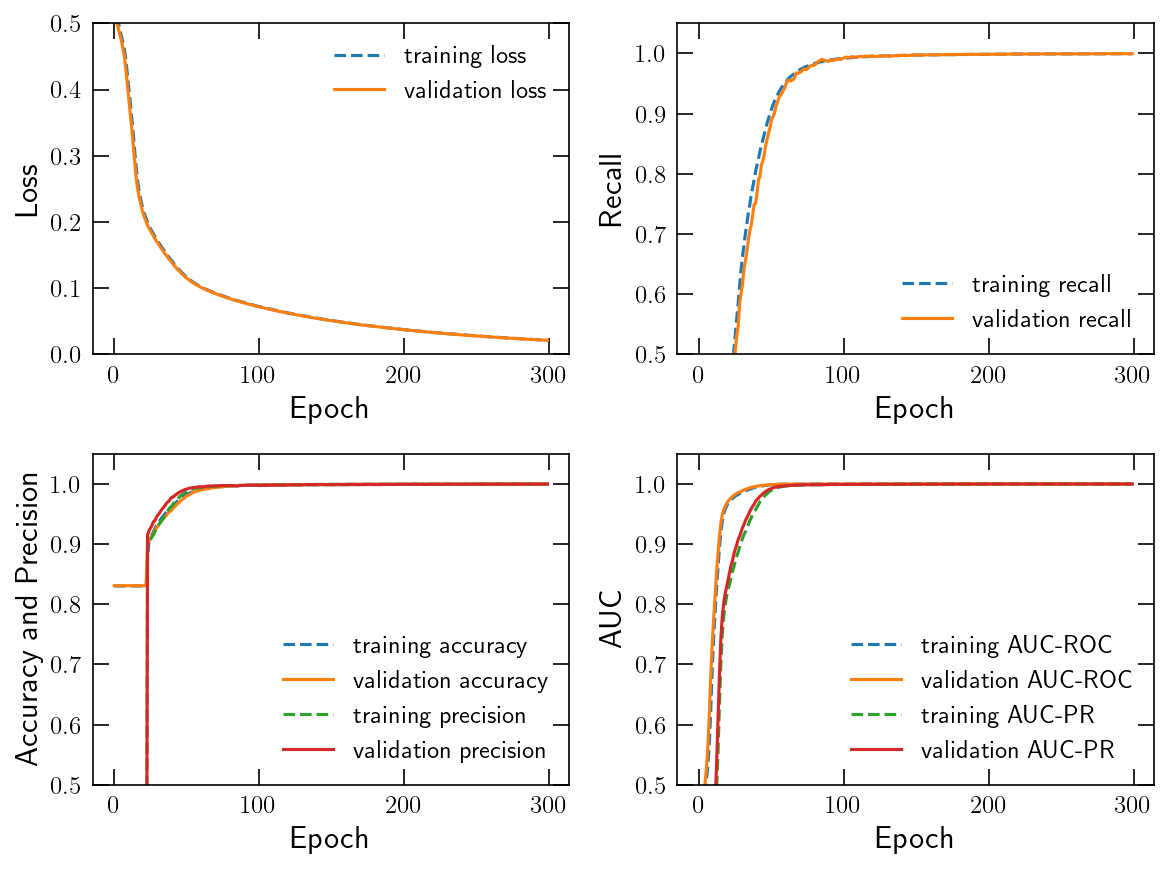

In [26]:
# Plot the loss and the prediction accuracy metric as a function of epoch

figure = plt.figure(figsize=(8,6))

ax = plt.subplot(2,2,1)
ax.plot(history.history['loss'], '--', label='training loss')
ax.plot(history.history['val_loss'], label='validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_ylim(0, 0.5)
plt.legend()

ax = plt.subplot(2,2,2)
ax.plot(history.history['recall_1'], '--', label='training recall')
ax.plot(history.history['val_recall_1'], label='validation recall')
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')
ax.set_ylim(0.5, 1.05)
plt.legend()

ax = plt.subplot(2,2,3)
ax.plot(history.history['acc'], '--', label='training accuracy')
ax.plot(history.history['val_acc'], label='validation accuracy')
ax.plot(history.history['precision_1'], '--', label='training precision')
ax.plot(history.history['val_precision_1'], label='validation precision')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy and Precision')
ax.set_ylim(0.5, 1.05)
plt.legend()

ax = plt.subplot(2,2,4)
ax.plot(history.history['auc_2'], '--', label='training AUC-ROC')
ax.plot(history.history['val_auc_2'], label='validation AUC-ROC')
ax.plot(history.history['auc_3'], '--', label='training AUC-PR')
ax.plot(history.history['val_auc_3'], label='validation AUC-PR')
ax.set_xlabel('Epoch')
ax.set_ylabel('AUC')
ax.set_ylim(0.5, 1.05)
plt.legend()

plt.tight_layout();